In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from shapely.geometry import Point


# Load your historical stock data
# Replace 'your_data.csv' with the path to your data file
data = pd.read_csv(r"C:\GEE project\Singapore\MYD11A2.061_1km_aid0001.csv")

# Preprocess the data
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
# Combine latitude and longitude to create a geometry column with Point objects
geometry = [Point(lon, lat) for lon, lat in zip(data['lon'], data['lat'])]
gdf = gpd.GeoDataFrame(data, geometry=geometry, crs='EPSG:4326')

<Axes: >

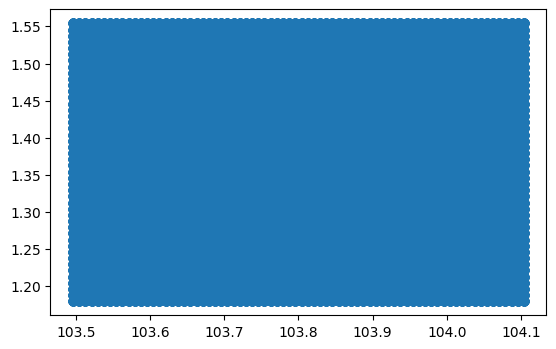

In [5]:
gdf.plot()

In [6]:
gdf

,Unnamed: 0,lat,lon,crs,LST_Day_1km,LST_Night_1km,QC_Day,QC_Night,geometry
time,,,,,,,,,
2021-12-27,0,1.554167,103.495833,-127,301.92,NaN,65.0,2.0,POINT (103.49583 1.55417)
2021-12-27,1,1.554167,103.504167,-127,301.88,NaN,65.0,2.0,POINT (103.50417 1.55417)
2021-12-27,2,1.554167,103.512500,-127,301.44,NaN,65.0,2.0,POINT (103.51250 1.55417)
2021-12-27,3,1.554167,103.520833,-127,299.74,NaN,65.0,2.0,POINT (103.52083 1.55417)
2021-12-27,4,1.554167,103.529167,-127,298.48,NaN,65.0,2.0,POINT (103.52917 1.55417)
...,...,...,...,...,...,...,...,...,...
2023-01-01,159983,1.179167,104.070833,-127,NaN,NaN,3.0,3.0,POINT (104.07083 1.17917)
2023-01-01,159984,1.179167,104.079167,-127,305.16,NaN,NaN,2.0,POINT (104.07917 1.17917)
2023-01-01,159985,1.179167,104.087500,-127,305.74,NaN,NaN,2.0,POINT (104.08750 1.17917)


In [8]:
data=gdf
# Create sequences for the LSTM
sequence_length = 20  # Tweak this value based on your data
sequences = []
next_data_point = []

for i in range(len(data) - sequence_length):
    sequences.append(data[['geometry','LST_Day_1km']].values[i:i + sequence_length])
    next_data_point.append(data[['geometry', 'LST_Day_1km']].values[i + sequence_length])

X = np.array(sequences)
y = np.array(next_data_point)

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=2))  # Adjust units for the number of features (lat and lon)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=2, batch_size=32)

# Make predictions
predicted_stock_prices = model.predict(X_test)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)

# Plot the actual and predicted prices
plt.plot(data.index[train_size + sequence_length:], data['geometry'][train_size + sequence_length:], label='Actual coordinates')
plt.plot(data.index[train_size + sequence_length:], predicted_stock_prices[:, 0], label='Predicted coordinates')
plt.plot(data.index[train_size + sequence_length:], data['LST_Day_1km'][train_size + sequence_length:], label='Actual temp')
plt.plot(data.index[train_size + sequence_length:], predicted_stock_prices[:, 1], label='Predicted temp')
plt.legend()
plt.show()

# Evaluate the model (you can use various metrics)
#from sklearn.metrics import mean_squared_error
#mse_lat = mean_squared_error(data['geometry'][train_size + sequence_length:], predicted_stock_prices[:, 0])
#mse_lon = mean_squared_error(data['LST_Day_1km'][train_size + sequence_length:], predicted_stock_prices[:, 1])
#print(f"Mean Squared Error for Latitude: {mse_lat}")
#print(f"Mean Squared Error for Longitude: {mse_lon}")
